## Spyglass tutorial 0

**Note: make a copy of this notebook and run the copy to avoid git conflicts in the future**

This is the zeroth in a multi-part tutorial on the Spyglass pipeline used in Loren Frank's lab, UCSF. It gives a general introduction to Datajoint and shows how to insert an NWB file into the Datajoint database, inspect and query the data, and delete it.

Let's start by importing the `spyglass` package, along with a few others. 

In [15]:
import os
import numpy as np

import spyglass as sg
import spyglass.common as sgc
import datajoint as dj

# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)
warnings.simplefilter('ignore', category=UserWarning)

### Set our environment variables

In [9]:
from pathlib import Path
os.environ['SPYGLASS_BASE_DIR'] = "/stelmo/nwb/"
os.environ['SPYGLASS_RECORDING_DIR'] = "/stelmo/nwb/recording"
os.environ['SPYGLASS_SORTING_DIR'] = "/stelmo/nwb/sorting"
os.environ['SPYGLASS_WAVEFORMS_DIR'] = "/stelmo/nwb/waveforms"
os.environ['SPYGLASS_TEMP_DIR'] = "/stelmo/nwb/tmp"
os.environ['KACHERY_DAEMON_HOST'] = "typhoon"
os.environ['KACHERY_DAEMON_PORT'] = "14747"
os.environ['KACHERY_STORAGE_DIR'] = "/stelmo/nwb/kachery-storage"
os.environ['KACHERY_TEMP_DIR'] = "/stelmo/nwb/tmp"
os.environ['FIGURL_CHANNEL'] = "franklab2"
os.environ['DJ_SUPPORT_FILEPATH_MANAGEMENT'] = "TRUE"
dj.config["enable_python_native_blobs"] = True

### Visualizing the database

Datajoint enables users to use Python to build and interact with a *relational database*, which is a fancy way of saying "a set of tables that are related to one another in some way." The following diagram (called *entity relationship diagram*) shows all the tables in our database and their relationships.

Polygons are tables:
* Blue oval: tables whose entries are imported from external files (e.g. NWB file).
* Green rectangle: tables whose entries are entered manually.
* Red circle: tables whose entries are computed from entries of other tables.
* No shape (only text): tables whose entries are part of the table upstream

Lines are *dependencies* between tables:
* Bold lines: downstream table inherits the *primary key* ^ of upstream table as its sole primary key
* Solid lines: downstream table inherits the primary key of upstream table as part of its primary key
* Dashed lines: downstream table inherits the primary key of upstream table as non-primary key

^ Primary key: a set of attributes (i.e. column names) used to uniquely define an entry (i.e. a row)

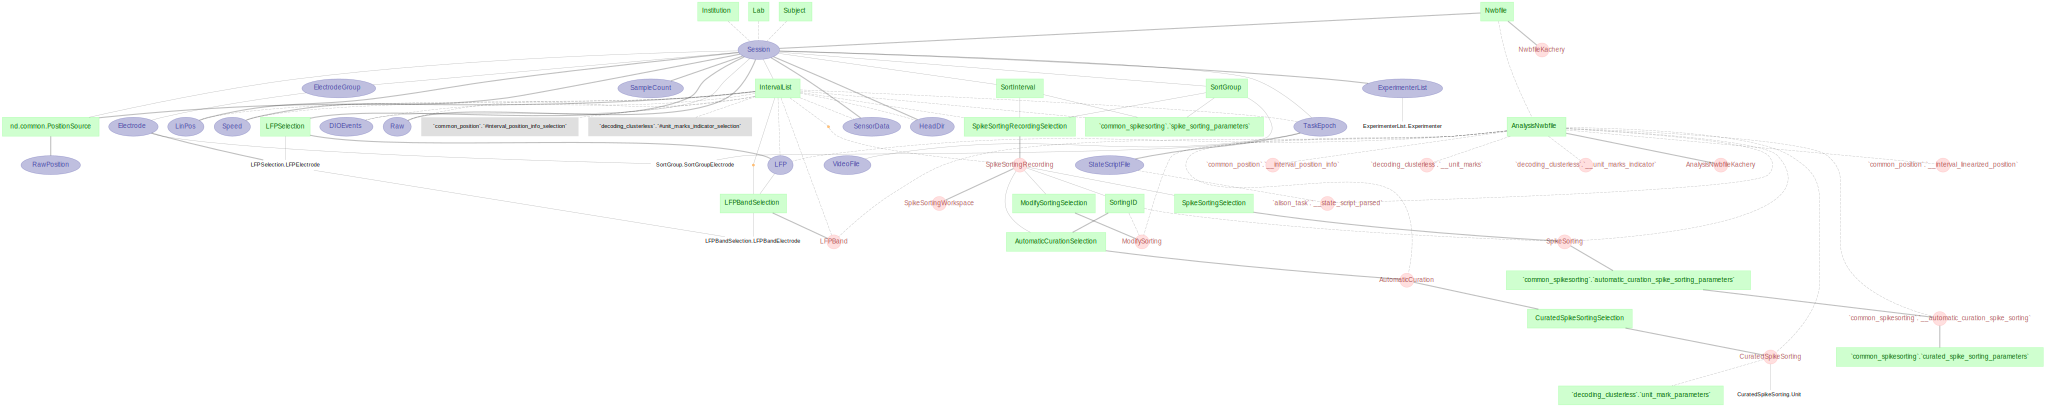

In [4]:
# Draw tables that are three levels below and one level above Session 
dj.ERD(sgc.Session)-1+3

### Example data

Now that we have a general idea of how our database is organized, we will try inserting new data to it. We assume that the data is a neural recording (along with other auxiliary data) that has already been converted to the NWB format. For the purposes of this tutorial, we will use `montague20200802_tutorial.nwb`. If you're accessing the Frank lab database on the UCSF network, this file can be found in `/stelmo/nwb/raw` directory (assuming you have mounted `stelmo` at `/`). If you do not have access to Frank lab database, then download `montague20200802.nwb` from [here](https://www.dropbox.com/s/srra33e0igaj5rm/beans20190718.nwb?dl=0) - it is rather big (~ 70 GB) so be aware of that. 

Once you have the NWB file, you should copy it and rename the copy to something unique (e.g. `montague20200802_yourname.nwb`). This is because many people will be using this example file to practice inserting data, and a file can only be inserted once (the file name acts as a *primary key* in the `Session` table). 

In [2]:
# Define the name of the file that you copied and renamed; make sure it's something unique. 
nwb_file_name = 'montague20200802_tutorial.nwb'
filename, file_extension = os.path.splitext(nwb_file_name)
# This is a copy of the original nwb file, except it doesn't contain the raw data (for storage reasons)
nwb_file_name2 = filename + '_' + file_extension

### Inserting data

An NWB file contains a lot of information, including information about the experimenter (e.g. who did the experiment, where was it done, etc); the animal's behavior (e.g. video recording of the animal's position in an environment during the experiment); the neural activity (extracellular recording of multiple brain areas), etc... We wish to enter this information into the tables of our Datajoint database so that we can easily access them later. If we have an NWB file that has been properly generated, this is straightforward: we can run the `sg.insert_session` function, which will populate many of the tables automatically. Let's do this for our example NWB file.

Note: this may take a while because it makes a copy of the NWB file.

In [10]:
sg.insert_sessions(nwb_file_name)

### Inspecting data

To look at the tables, just call it (don't forget the `()` at the end, as tables are like Python classes). Let's try calling the `Lab` table.

In [16]:
sgc.Lab()

lab_name
Loren Frank


There is only one attribute (`lab_name`) and one entry (`Loren Frank`) in this table. Note that even though `Lab` is one of the tables that has to be manually entered (i.e. the green rectangles in our ERD), `sg.insert_sessions` populates it from the NWB file.

Let's look at a more interesting table, `Session`. This table has multiple attributes, including one that is in bold, `nwb_file_name`. The bolding of the attribute name indicates that is it part of the primary key. Given that many downstream tables are connected to `Session` via bold lines, you can use this attribute to uniquely define data entries in many tables in our database.

In [17]:
sgc.Session()

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
beans20190718_austin_.nwb,Beans,"University of California, San Francisco",Loren Frank,beans_01,Reinforcement leaarning,2019-07-18 15:29:47,1970-01-01 00:00:00,Reinforcement learning
beans20190718_dgramling_.nwb,Beans,"University of California, San Francisco",Loren Frank,beans_01,Reinforcement leaarning,2019-07-18 15:29:47,1970-01-01 00:00:00,Reinforcement learning
beans20190718_emonroe_.nwb,Beans,"University of California, San Francisco",Loren Frank,beans_01,Reinforcement leaarning,2019-07-18 15:29:47,1970-01-01 00:00:00,Reinforcement learning
beans20190718_sc4712_.nwb,Beans,"University of California, San Francisco",Loren Frank,beans_01,Reinforcement leaarning,2019-07-18 15:29:47,1970-01-01 00:00:00,Reinforcement learning
CH5_20210109_.nwb,CH5,"University of California, San Francisco",Loren Frank,1,Exploration,2021-01-09 09:35:35,1970-01-01 00:00:00,"Four-box, six-arm automated track"
CH5_20210110_.nwb,CH5,"University of California, San Francisco",Loren Frank,2,Exploration,2021-01-10 08:31:57,1970-01-01 00:00:00,"Four-box, six-arm automated track"
CH5_20210111_.nwb,CH5,"University of California, San Francisco",Loren Frank,3,Exploration,2021-01-11 10:22:20,1970-01-01 00:00:00,"Four-box, six-arm automated track"
CH5_20210112_.nwb,CH5,"University of California, San Francisco",Loren Frank,4,Exploration,2021-01-12 10:26:58,1970-01-01 00:00:00,"Four-box, six-arm automated track"
CH5_20210113_.nwb,CH5,"University of California, San Francisco",Loren Frank,1,Alternation 234,2021-01-13 08:50:48,1970-01-01 00:00:00,"Four-box, six-arm automated track"
CH5_20210114_.nwb,CH5,"University of California, San Francisco",Loren Frank,2,Alternation 234,2021-01-14 08:49:40,1970-01-01 00:00:00,"Four-box, six-arm automated track"


We can also look at the documentation, or docstring, associated with the Session table using the `describe` method. This shows the primary and secondary dependencies of the `Session` table, which are separated by `---`.<br>The keys that you see when you call the `Session` table are inherited from the tables that will be returned by `describe`, including `Nwbfile`, `Subject`, `Institution`, and `Lab`. 

In [42]:
sgc.Session.describe()

# Table for holding experimental sessions.
-> sgc.Nwbfile
---
-> [nullable] sgc.Subject
-> [nullable] sgc.Institution
-> [nullable] sgc.Lab
session_id=null      : varchar(200)                 
session_description  : varchar(2000)                
session_start_time   : datetime                     
timestamps_reference_time : datetime                     
experiment_description=null : varchar(2000)                



'# Table for holding experimental sessions.\n-> sgc.Nwbfile\n---\n-> [nullable] sgc.Subject\n-> [nullable] sgc.Institution\n-> [nullable] sgc.Lab\nsession_id=null      : varchar(200)                 \nsession_description  : varchar(2000)                \nsession_start_time   : datetime                     \ntimestamps_reference_time : datetime                     \nexperiment_description=null : varchar(2000)                \n'

### Querying tables
To look at specific entries from a table, you can use a key-value pair, or a dictionary as your search condition. First, call the table `sgc.Session`, then add a `&` operator and your search condition. As an example, let's search for the entry in `Session` whose `nwb_file_name` matches our example NWB file.

In [43]:
sgc.Session & {'nwb_file_name':nwb_file_name2}

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
montague20200802_tutorial_.nwb,montague,"University of California, San Francisco",Loren Frank,montague_16,Eight arm flexible spatial task,2020-08-02 10:34:34,1970-01-01 00:00:00,Eight arm flexible spatial task


Now let's visualize the connection to a downstream table: `Raw`.

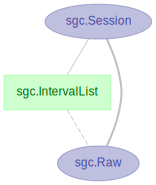

In [46]:
dj.ERD(sgc.Session) + dj.ERD(sgc.Raw)

This table is connected to `Session` table with a bold line, so it has the same primary key. Let's query the `Raw` table for the example NWB file we're using.

In [48]:
sgc.Raw & {'nwb_file_name':nwb_file_name2}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,raw_object_id the NWB object ID for loading this object from the file,"sampling_rate Sampling rate calculated from data, in Hz",comments,description
montague20200802_tutorial_.nwb,raw data valid times,ea2054f5-624d-4143-85ac-ca108145fb7b,30000.0,No comment,Recording of extracellular voltage


The `IntervalList` table is an intermediate table connected to both the `Session` table with a solid line, and the `Raw` table with a dashed line. `IntervalList` inherits `nwb_file_name` as one of the two attributes that make up the primary key, thus the bold line. This means that you need to provide both `nwb_file_name` and `interval_list_name` to uniquely identify an entry.

In [49]:
sgc.IntervalList & {'nwb_file_name':nwb_file_name2}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,valid_times numpy array with start and end times for each interval
montague20200802_tutorial_.nwb,01_s1,=BLOB=
montague20200802_tutorial_.nwb,02_r1,=BLOB=
montague20200802_tutorial_.nwb,03_s2,=BLOB=
montague20200802_tutorial_.nwb,04_r2,=BLOB=
montague20200802_tutorial_.nwb,05_s3,=BLOB=
montague20200802_tutorial_.nwb,montague20200802_tutorial_.nwb_02_r1_first180_10franklab_default_hippocampus_recording,=BLOB=
montague20200802_tutorial_.nwb,pos 0 valid times,=BLOB=
montague20200802_tutorial_.nwb,pos 1 valid times,=BLOB=
montague20200802_tutorial_.nwb,pos 2 valid times,=BLOB=
montague20200802_tutorial_.nwb,pos 3 valid times,=BLOB=


As you can see, some of the data is shown in the table (e.g. `interval_list_name`) while others are obscured (e.g. `valid_times` are shown as `=BLOB=`). To inspect the data, use the `fetch` (for getting multiple entries) or `fetch1` (for getting a single entry) methods. The following query returns `valid_times` of an interval list called `04_r2`.

In [50]:
(sgc.IntervalList & {'nwb_file_name':nwb_file_name2,
                     'interval_list_name':'04_r2'}).fetch1('valid_times')

array([[1.59640235e+09, 1.59640792e+09]])

Query supports many operations and conditions - just make sure the conditions are in the form of a dictionary. For example, `-` is like the set-theoretic complement. The following query returns all the `interval_list_name` entries that are not `01_s1` or `04_r2`.

In [53]:
(((sgc.IntervalList & {'nwb_file_name':nwb_file_name2}) - 
                  {'interval_list_name':'01_s1'}) - 
                  {'interval_list_name':'04_r2'}).fetch('interval_list_name')

array(['02_r1', '03_s2', '05_s3',
       'montague20200802_tutorial_.nwb_02_r1_first180_10franklab_default_hippocampus_recording',
       'pos 0 valid times', 'pos 1 valid times', 'pos 2 valid times',
       'pos 3 valid times', 'pos 4 valid times', 'raw data valid times'],
      dtype=object)

Feel free to inspect other tables and learn what kind of data they contain.

### Deleting data 

Another neat feature of Datajoint is that it automatically maintains the integrity of your data. For example, if we were to delete our entry in the `Session` table, the associated entries in all of the downstream tables (e.g. `Raw`, `IntervalList`, `ElectrodeGroup` to name a few) will also be deleted. That way, there is no 'orphan' data whose origin cannot be tracked. We will do this now using the `delete` method.

In [27]:
# our data is currently in Session table
sgc.Session & {'nwb_file_name':nwb_file_name2}

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
montague20200802_tutorial_.nwb,montague,"University of California, San Francisco",Loren Frank,montague_16,Eight arm flexible spatial task,2020-08-02 10:34:34,1970-01-01 00:00:00,Eight arm flexible spatial task


In [ ]:
# Type `yes` when prompted to delete
(sgc.Session & {'nwb_file_name':nwb_file_name2}).delete()

In [55]:
# Check that delete worked
sgc.Session & {'nwb_file_name':nwb_file_name2}

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description


The `delete` method is useful when you need to re-do something. We discourage editing an entry because this will affect the associated entries in downstream tables and violate data integrity. Instead it is recommended that you just delete and re-enter it. This is easy to do, as most data entry is automated in our pipeline.

In [56]:
# Entries are also gone from downstream tables, e.g. IntervalList
sgc.IntervalList & {'nwb_file_name':nwb_file_name2}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,valid_times numpy array with start and end times for each interval


We're almost done! Not only should we delete our entry from `Session`, we should also delete the associated entry in `Nwbfile`. Recall from the entity relationship diagram that `Nwbfile` is upstream of `Session`. That means getting rid of our entry from `Session` doesn't affect the corresponding entry in `Nwbfile` - this has to be manually removed. To do so, we again use the `delete` method, but in the case of `Nwbfile` there is an extra step: we need to remove the NWB file itself as well as the entry from `Nwbfile` table. To remove the files, we run the `cleanup` method with the `delete_files` argument as `True`. 

Note that the same idea applies to deleting files from the `AnalysisNwbfile` table. 

In [57]:
# Check out the Nwb file
sgc.Nwbfile & {'nwb_file_name':nwb_file_name2}

nwb_file_name name of the NWB file,nwb_file_abs_path
montague20200802_tutorial_.nwb,=BLOB=


In [58]:
# Let's delete the entry
(sgc.Nwbfile & {'nwb_file_name':nwb_file_name2}).delete()

Deleting 1 rows from `common_nwbfile`.`nwbfile`
Commit deletes? [yes, No]: yes
Deletes committed.


1

In [63]:
# Note that the file (ends with _.nwb) has not been deleted, even though the entry is
!ls $SPYGLASS_BASE_DIR/raw/montague20200802*

/stelmo/nwb//raw/montague20200802_tutorial.nwb
/stelmo/nwb//raw/montague20200802_tutorial_.nwb


In [64]:
# We clean it up
sgc.Nwbfile().cleanup(delete_files=True)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


In [65]:
# Now the file (ending with _.nwb) is gone as well
!ls $SPYGLASS_BASE_DIR/raw/montague20200802*

/stelmo/nwb//raw/montague20200802_tutorial.nwb


### Creating a Lab Team

Before we end this tutorial, there is one last thing we must do: create a lab team. A lab team is a set of lab members who own a set of NWB files and the associated information in our Datajoint database. Think of this as a "subgroup" within the lab that collaborates on the same projects. Only the members of a lab team will be able to delete table entries they made (this permission system is not yet implemented; we're working on it). Right now we need to set a lab team so that the permission for manual curation of spike sorted data can be set (this will be covered in [tutorial 2](2_curation.ipynb)).

The `LabMember` table contains the list of lab members. It has a parts table called `LabMemberInfo`, where the Google account of each member can be found (for authentication purposes). Similarly, `LabTeam` table contains the list of lab teams and has a parts table called `LabTeamMember` which specifies which of the lab members (as entered in `LabMember`) belongs to each lab team. Both `LabMember` and `LabTeam` are `dj.Manual` tables, which means the data can be entered manually (although when we add our NWB file with `sg.insert_sessions(nwb_file_name)`, the owner of the NWB file (as specified in the `experimenter` field) is automatically entered into `LabMember` table). 

To proceed, we will create a new team using the `create_new_team` method of `LabTeam`. You will give this team a name, and add yourself (and your Google account) to this team. Later, when we do spike sorting, we will specify the team the sorting belongs to. This will give everyone in the team (in this case, just you) the permission to add curation labels.

In [66]:
# take a look at the lab members
sgc.LabMember()

lab_member_name,first_name,last_name
Alison Comrie,Alison,Comrie
Anagh Ravi,Anagh,Ravi
Anna Gillespie,Anna,Gillespie
Baibhav Sharma,Baibhav,Sharma
Cristofer Holobetz,Cristofer,Holobetz
Daniel Gramling,Daniel,Gramling
David Kastner,David,Kastner
Emily Monroe,Emily,Monroe
Eric Denovellis,Eric,Denovellis
FirstName LastName,FirstName,LastName


In [67]:
# LabMember also has a Parts table called LabMemberInfo
sgc.LabMember.LabMemberInfo()

lab_member_name,google_user_name used for permission to curate,datajoint_user_name used for permission to delete entries
Alison Comrie,comrie.alison@gmail.com,alison
Anagh Ravi,anaghsinha81@gmail.com,anagh
Baibhav Sharma,baibhavsharma.lab@gmail.com,bsharma
Cristofer Holobetz,cristofer.holobetz@berkeley.edu,
Daniel Gramling,dpeg22@gmail.com,dgramling
David Kastner,dbkastner@gmail.com,
Emily Monroe,emilymonroe95@gmail.com,emonroe
Eric Denovellis,edenovellis@gmail.com,edeno
FirstName LastName,gmail@gmail.com,user
Greer Williams,greer.williams@ucsf.edu,


In [73]:
# these are the existing lab teams
sgc.LabTeam()

team_name,team_description
ac_em_xs,
Alison Comrie,
Anagh Ravi,anagh
Anna Gillespie,
AutoTrack,physiological data from dorsal and intermediate hippocampus
Beans,test
BeansXulu,
despy,test
fig,test
Jennifer Guidera,


### We can now create a new team (if needed) and add yourself to the LabMember table
First, let's set a unique team name. Then we can name the members who are a part of that team within a `list`. Our last step before creating the team is to add a description, which can be helpful, but is also optional.

Now that we've created a team, let's add you as a member of the Lab. Edit the second cell to include your full name, gmail email address, and your datajoint username.

In [31]:
team_name = 'tutorial'
team_members = ['First Member', 'Second Member']
team_description = 'tutorial'
sgc.LabTeam().create_new_team(team_name=team_name,
                          team_members=team_members,
                          team_description=team_description)

Please add the Google user ID for First Member in the LabMember.LabMemberInfo table if you want to give them permission to manually curate sortings by this team.
Please add the Google user ID for Second Member in the LabMember.LabMemberInfo table if you want to give them permission to manually curate sortings by this team.


In [32]:
sgc.LabMember.LabMemberInfo.insert([['First Member', 'fmem_39@gmail.com', 'fmember'],
                                ['Second Member', '10seconds@gmail.com', 'second']])

And now we can check to make sure you've been added to the `LabMember` table

In [39]:
sgc.LabMember.LabMemberInfo()

lab_member_name,google_user_name used for permission to curate,datajoint_user_name used for permission to delete entries
Alison Comrie,comrie.alison@gmail.com,alison
Anagh Ravi,anaghsinha81@gmail.com,anagh
Cristofer Holobetz,cristofer.holobetz@berkeley.edu,
Daniel Gramling,dpeg22@gmail.com,dgramling
David Kastner,dbkastner@gmail.com,
Emily Monroe,emilymonroe95@gmail.com,emonroe
Eric Denovellis,edenovellis@gmail.com,edeno
FirstName LastName,gmail@gmail.com,user
Greer Williams,greer.williams@ucsf.edu,
Jennifer Guidera,jenniferguidera@gmail.com,
